In [1]:
# pip install pandas --trusted-host pypi.python.org --trusted-host files.pythonhosted.org --trusted-host pypi.org
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from patsy import dmatrix, dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [236]:
df = pd.read_csv('동박데이터-등차결측치.csv', thousands = ',')  # 천 단위 구분 반점(,) 없애기
df.head()

,date,time,appliedcurrent,voltage,Cl,TOC,A,B,C,D,activatedcarbon,tensilestrength,elongation,glossiness,Mside,Sside,Curl
0,05월 13일,3,1.3,NaN,NaN,NaN,358.0,1090.0,1272.0,373.0,2.4,34.8,7.9,115.0,1.39,0.22,NaN
1,05월 13일,7,1.3,NaN,NaN,NaN,358.0,1090.0,1272.0,373.0,2.4,35.8,7.6,127.0,1.47,0.23,NaN
2,05월 13일,11,1.3,NaN,34.0,43.3,358.0,1090.0,1272.0,373.0,2.4,36.4,8.6,154.0,1.30,0.25,NaN
3,05월 13일,15,1.3,NaN,NaN,NaN,358.0,1090.0,1272.0,373.0,2.4,36.7,10.3,176.0,1.26,0.25,NaN
4,05월 13일,19,1.3,NaN,NaN,NaN,358.0,1090.0,1272.0,373.0,2.4,36.7,9.6,260.0,1.05,0.25,NaN


## 결측치 대체

In [237]:
# 공정액은 두 값들 사이를 등차로 결측치 보간
# 나머지는 평균

cl = []
toc = []
# null이 아닌 인덱스 append
for i in range(len(df['Cl'])):
    if df['Cl'].notnull()[i]:
        cl.append(i)
for i in range(len(df['TOC'])):
    if df['TOC'].notnull()[i]:
        toc.append(i)

# 공차를 구해서 빈 값들에 채워넣기
for j in range(len(cl)):
    if j < len(cl)-1:
        if cl[j+1] - cl[j] > 1: # 사이에 결측치 있으면
            diff = (df['Cl'][cl[j+1]] - df['Cl'][cl[j]]) / (cl[j+1] - cl[j])
            for k in range(cl[j],cl[j+1]):
                df['Cl'][k] = df['Cl'][cl[j]] + diff*(k-cl[j])
for j in range(len(toc)):
    if j < len(toc)-1:
        if toc[j+1] - toc[j] > 1: # 사이에 결측치 있으면
            diff = (df['TOC'][toc[j+1]] - df['TOC'][toc[j]]) / (toc[j+1] - toc[j])
            for k in range(toc[j],toc[j+1]):
                df['TOC'][k] = df['TOC'][toc[j]] + diff*(k-toc[j])          
        

C:\Users\cmson\AppData\Local\Temp\ipykernel_11204\3595720260.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cl'][k] = df['Cl'][cl[j]] + diff*(k-cl[j])
C:\Users\cmson\AppData\Local\Temp\ipykernel_11204\3595720260.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TOC'][k] = df['TOC'][toc[j]] + diff*(k-toc[j])


In [238]:
# 평균으로 대체시 기존 값들과 편차 크므로, bfill, ffill 사용
df['Cl'] = df['Cl'].fillna(method='ffill') .fillna(method='bfill')
df['TOC'] = df['TOC'].fillna(method='ffill') .fillna(method='bfill')

In [239]:
# 변수별 평균으로 결측치 대체
df = df.fillna(df.mean())
df.head()

C:\Users\cmson\AppData\Local\Temp\ipykernel_11204\2272151833.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = df.fillna(df.mean())


,date,time,appliedcurrent,voltage,Cl,TOC,A,B,C,D,activatedcarbon,tensilestrength,elongation,glossiness,Mside,Sside,Curl
0,05월 13일,3,1.3,4.351327,34.000000,43.300000,358.0,1090.0,1272.0,373.0,2.4,34.8,7.9,115.0,1.39,0.22,3.790875
1,05월 13일,7,1.3,4.351327,34.000000,43.300000,358.0,1090.0,1272.0,373.0,2.4,35.8,7.6,127.0,1.47,0.23,3.790875
2,05월 13일,11,1.3,4.351327,34.000000,43.300000,358.0,1090.0,1272.0,373.0,2.4,36.4,8.6,154.0,1.30,0.25,3.790875
3,05월 13일,15,1.3,4.351327,34.566667,47.966667,358.0,1090.0,1272.0,373.0,2.4,36.7,10.3,176.0,1.26,0.25,3.790875
4,05월 13일,19,1.3,4.351327,35.133333,52.633333,358.0,1090.0,1272.0,373.0,2.4,36.7,9.6,260.0,1.05,0.25,3.790875


## 상관관계 분석

C:\Users\cmson\AppData\Local\Temp\ipykernel_11204\3322554149.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


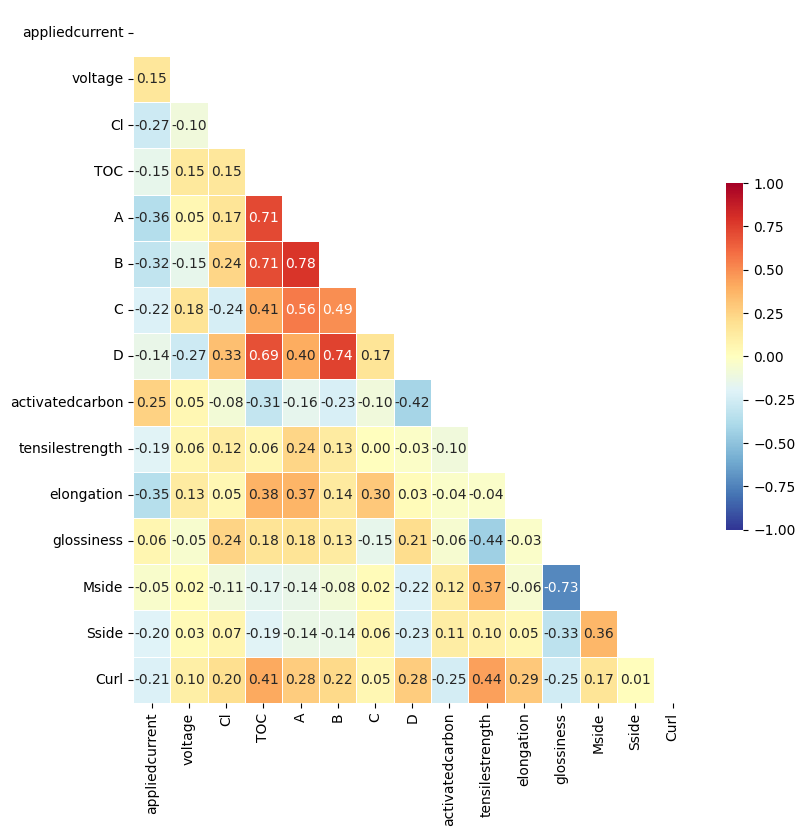

In [240]:
# heatmap
corr = df.drop(['date','time'], axis=1).corr()
# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(9,9) )

# 삼각형 마스크(위 : True, 아래 : False)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값 표시
            mask=mask,      # 표시하지 않을 마스크 부분 지정
            linewidths=.5,  # 경계면 구분
            cbar_kws={"shrink": .5},# 컬러바 크기 절반
            vmin = -1,vmax = 1,   # 컬러바 범위 -1 ~ 1
            fmt = '.2f'
           )  
plt.show()

## Train-Test split

In [241]:
x = df.drop(['date','time','tensilestrength','elongation','glossiness','Mside','Sside','Curl'], axis=1).values
y1, y2, y3, y4, y5, y6 = df['tensilestrength'], df['elongation'], df['glossiness'], df['Mside'], df['Sside'], df['Curl']

In [242]:
x_train, x_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test, y4_train, y4_test,y5_train, y5_test,y6_train, y6_test = train_test_split(x,y1,y2,y3,y4,y5,y6, train_size=0.7)

## PCA

In [243]:
scale = StandardScaler()
x_scaledtrain = scale.fit_transform(x_train)
x_scaledtest = scale.transform(x_test)

In [244]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5) # 주성분 5개
x_pca_train = pca.fit_transform(x_scaledtrain)
x_pca_test = pca.transform(x_scaledtest)

print(pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_)  # 89.81% 설명

[0.39829594 0.17404421 0.11700456 0.11299929 0.10115002]


0.9034940272175283

## Multiple Linear Regression

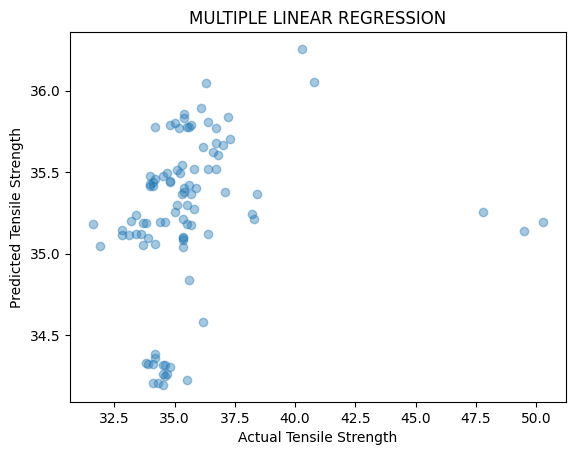

0.06533922206747989


In [245]:
mlr = LinearRegression()
mlr.fit(x_pca_train, y1_train)
y1_predict = mlr.predict(x_pca_test)

plt.scatter(y1_test, y1_predict, alpha=0.4)
plt.xlabel("Actual Tensile Strength")
plt.ylabel("Predicted Tensile Strength")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()
print(mlr.score(x_pca_train, y1_train))

In [246]:
# PCA R score
pca_score = []
mlr = LinearRegression()
mlr.fit(x_pca_train, y1_train)
pca_score.append(mlr.score(x_pca_train, y1_train))
mlr = LinearRegression()
mlr.fit(x_pca_train, y2_train)
pca_score.append(mlr.score(x_pca_train, y2_train))
mlr = LinearRegression()
mlr.fit(x_pca_train, y3_train)
pca_score.append(mlr.score(x_pca_train, y3_train))
mlr = LinearRegression()
mlr.fit(x_pca_train, y4_train)
pca_score.append(mlr.score(x_pca_train, y4_train))
mlr = LinearRegression()
mlr.fit(x_pca_train, y5_train)
pca_score.append(mlr.score(x_pca_train, y5_train))
mlr = LinearRegression()
mlr.fit(x_pca_train, y6_train)
pca_score.append(mlr.score(x_pca_train, y6_train))
pca_score

[0.06533922206747989,
 0.2845933224532844,
 0.18056587088376275,
 0.08178813559731801,
 0.10296605493164901,
 0.16145237622233466]

In [247]:
# PCA 안 한 R score
score = []
coef = []
mlr = LinearRegression()
mlr.fit(x_scaledtrain, y1_train)
score.append(mlr.score(x_scaledtrain, y1_train))
coef.append(mlr.coef_)
mlr = LinearRegression()
mlr.fit(x_scaledtrain, y2_train)
score.append(mlr.score(x_scaledtrain, y2_train))
coef.append(mlr.coef_)
mlr = LinearRegression()
mlr.fit(x_scaledtrain, y3_train)
score.append(mlr.score(x_scaledtrain, y3_train))
coef.append(mlr.coef_)
mlr = LinearRegression()
mlr.fit(x_scaledtrain, y4_train)
score.append(mlr.score(x_scaledtrain, y4_train))
coef.append(mlr.coef_)
mlr = LinearRegression()
mlr.fit(x_scaledtrain, y5_train)
score.append(mlr.score(x_scaledtrain, y5_train))
coef.append(mlr.coef_)
mlr = LinearRegression()
mlr.fit(x_scaledtrain, y6_train)
score.append(mlr.score(x_scaledtrain, y6_train))
coef.append(mlr.coef_)
print(score)

[0.10387774618849221, 0.4484196205081198, 0.24611621200243106, 0.13028057920807645, 0.16014568917049232, 0.20877721137001404]


In [248]:
for i in coef:
    print(i)

[-0.20031872  0.02600558  0.047127   -0.05490149  0.4898322   0.18662825
 -0.19999105 -0.6758694  -0.36993869]
[-0.98020113 -0.26902086  0.11837755  2.0949426   0.8475298  -1.77436649
  0.58780506 -0.7157248   0.4350869 ]
[  8.83113961  10.67350236   7.70094387  -8.73938961  39.61744695
  -7.14723226 -32.71300964  23.97426516   0.74055407]
[-0.03524221 -0.05044231 -0.00824287  0.06595625 -0.17081355  0.14739796
  0.03900559 -0.18594135  0.00947266]
[-0.00845085  0.00108122  0.00796197  0.00399704 -0.01745824  0.00674242
  0.00978711 -0.01345347  0.00190852]
[-0.75862855  0.48105971  0.30672327  1.51884441  0.82897097 -1.6826943
 -0.14102252  0.35208834 -0.53052341]


## MLR 변수 선택

### 인장강도

In [249]:
## 전진 단계별 선택법
variables = df.columns[2:11].tolist() ## 설명 변수 리스트
 
y = df['tensilestrength'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder, dtype='float64') ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = df[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [250]:

features = '+'.join(selected_variables)
print(features)

A+C+TOC+activatedcarbon+voltage


In [251]:
model = smf.ols(formula = 'tensilestrength ~' + features, data=df)
result = model.fit()
result.summary()
# Adj. R-squared : 0.115 
# F-statistic : 9.2  &   Prob(F-statistic) : 3.50e-08   -->통계적으로 유의한 모형
# intercept를 포함한 모든 항의 P>|t|가 0.05 이하이므로, 유의성을 지닌다

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        tensilestrength   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     9.200
Date:                Thu, 13 Oct 2022   Prob (F-statistic):           3.50e-08
Time:                        15:53:34   Log-Likelihood:                -708.43
No. Observations:                 318   AIC:                             1429.
Df Residuals:                     312   BIC:                             1451.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          30.6901      2.575     11.919      0.000      25.624      35.756
A                   0.0077      0.001      6.383      0.000       0.005       0.010
C                  -0.0014      0.000     -3.290      0.001      -0.002      -0.001
TOC                -0.0083      0.002     -3.658      0.000      -0.013      -0.004
activatedcarbon    -0.3975      0.176     -2.257      0.025      -0.744      -0.051
voltage             1.3094      0.602      2.174      0.030       0.124       2.495
==============================================================================
Omnibus:                      240.295   Durbin-Watson:                   0.550
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3565.677
Skew:                           3.014   Prob(JB):                         0.00
Kurtosis:                      18.257   Cond. No.                     2.33e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [252]:
#다중공선성 여부 확인
y, X = dmatrices("tensilestrength ~ " + features, data=df, return_type = "dataframe")
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)
# VIF가 모두 10이하 --> 다중공선성 문제 X

,VIF Factor,features
0,410.3,Intercept
1,2.5,A
2,1.5,C
3,2.3,TOC
4,1.1,activatedcarbon
5,1.1,voltage


### 연신율

In [253]:
## 전진 단계별 선택법
variables = df.columns[2:11].tolist() ## 설명 변수 리스트
 
y = df['elongation'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder, dtype='float64') ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = df[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [254]:
features = '+'.join(selected_variables)
print(features)

TOC+D+appliedcurrent+B+C+activatedcarbon


In [255]:
model = smf.ols(formula = 'elongation ~' + features, data=df)
result = model.fit()
result.summary()
# Adj. R-squared : 0.289 
# F-statistic : 26.77  &   Prob(F-statistic) : 1.63e-22   -->통계적으로 유의한 모형
# intercept를 포함한 모든 항의 P>|t|가 0.05 이하이므로, 95% 기준에서 유의성을 지닌다

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             elongation   R-squared:                       0.393
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     33.63
Date:                Thu, 13 Oct 2022   Prob (F-statistic):           3.32e-31
Time:                        15:53:35   Log-Likelihood:                -738.66
No. Observations:                 318   AIC:                             1491.
Df Residuals:                     311   BIC:                             1518.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          33.9582      2.942     11.542      0.000      28.169      39.747
TOC                 0.0270      0.003     10.270      0.000       0.022       0.032
D                  -0.0078      0.003     -2.655      0.008      -0.014      -0.002
appliedcurrent    -17.2509      2.141     -8.057      0.000     -21.464     -13.038
B                  -0.0045      0.001     -4.432      0.000      -0.006      -0.002
C                   0.0013      0.000      2.752      0.006       0.000       0.002
activatedcarbon     0.4876      0.213      2.290      0.023       0.069       0.907
==============================================================================
Omnibus:                        1.826   Durbin-Watson:                   0.964
Prob(Omnibus):                  0.401   Jarque-Bera (JB):                1.651
Skew:                           0.058   Prob(JB):                        0.438
Kurtosis:                       3.333   Cond. No.                     3.54e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.54e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [256]:
#다중공선성 여부 확인
y, X = dmatrices("elongation ~ " + features, data=df, return_type = "dataframe")
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)
# VIF가 모두 10이하 --> 다중공선성 문제 X

,VIF Factor,features
0,441.5,Intercept
1,2.5,TOC
2,3.5,D
3,1.2,appliedcurrent
4,3.8,B
5,1.6,C
6,1.4,activatedcarbon


### 광택도

In [257]:
## 전진 단계별 선택법
variables = df.columns[2:11].tolist() ## 설명 변수 리스트
 
y = df['glossiness'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder, dtype='float64') ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = df[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [258]:
features = '+'.join(selected_variables)

In [259]:
model = smf.ols(formula = 'glossiness ~ 0+' + features, data=df)
result = model.fit()
result.summary()
# Adj. R-squared : 0.151 
# F-statistic : 12.31  &   Prob(F-statistic) : 6.66e-11   -->통계적으로 유의한 모형
# 모든 항의 P>|t|가 0.05 이하이므로, 95% 기준에서 유의성을 지니지만, intercept는 0.285이므로 제외시킨다.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             glossiness   R-squared (uncentered):                   0.890
Model:                            OLS   Adj. R-squared (uncentered):              0.888
Method:                 Least Squares   F-statistic:                              632.9
Date:                Thu, 13 Oct 2022   Prob (F-statistic):                   7.26e-149
Time:                        15:53:35   Log-Likelihood:                         -1822.7
No. Observations:                 318   AIC:                                      3653.
Df Residuals:                     314   BIC:                                      3668.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Cl                 1.6485      0.652      2.530      0.012       0.366       2.931
C                 -0.0641      0.014     -4.468      0.000      -0.092      -0.036
A                  0.1735      0.033      5.270      0.000       0.109       0.238
appliedcurrent   131.1446     13.692      9.578      0.000     104.204     158.085
==============================================================================
Omnibus:                       25.607   Durbin-Watson:                   0.529
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.128
Skew:                          -0.642   Prob(JB):                     1.74e-07
Kurtosis:                       3.838   Cond. No.                     3.60e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 3.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [260]:
#다중공선성 여부 확인
y, X = dmatrices('glossiness ~ ' + "0 + Cl + C + A + appliedcurrent", data=df, return_type = "dataframe")
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)
# Cl, C, appliedcurrent의 VIF가 10초과 -> 가장 큰 VIF를 가진 appliedcurrent를 제거 

,VIF Factor,features
0,12.3,Cl
1,12.7,C
2,9.4,A
3,18.9,appliedcurrent


In [261]:
model = smf.ols(formula = 'glossiness ~ ' + "Cl + C + A", data=df)
result = model.fit()
result.summary()
# Adj. R-squared : 0.151 
# F-statistic : 12.31  &   Prob(F-statistic) : 6.66e-11   -->통계적으로 유의한 모형
# 모든 항의 P>|t|가 0.05 이하이므로, 95% 기준에서 유의성을 지니지만, intercept는 0.285이므로 제외시킨다.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             glossiness   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     15.94
Date:                Thu, 13 Oct 2022   Prob (F-statistic):           1.14e-09
Time:                        15:53:36   Log-Likelihood:                -1826.9
No. Observations:                 318   AIC:                             3662.
Df Residuals:                     314   BIC:                             3677.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    186.8405     20.734      9.011      0.000     146.046     227.635
Cl             1.4031      0.702      2.000      0.046       0.023       2.784
C             -0.0657      0.015     -4.400      0.000      -0.095      -0.036
A              0.1590      0.033      4.797      0.000       0.094       0.224
==============================================================================
Omnibus:                       28.110   Durbin-Watson:                   0.512
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.014
Skew:                          -0.699   Prob(JB):                     4.11e-08
Kurtosis:                       3.783   Cond. No.                     5.38e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [262]:
#다중공선성 여부 확인
y, X = dmatrices('glossiness ~ ' + "Cl + C + A", data=df, return_type = "dataframe")
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)
# Cl, C, appliedcurrent의 VIF가 10초과 -> 가장 큰 VIF를 가진 appliedcurrent를 제거 

,VIF Factor,features
0,23.6,Intercept
1,1.2,Cl
2,1.7,C
3,1.7,A


### 조도 M면

In [268]:
## 전진 단계별 선택법
variables = df.columns[2:11].tolist() ## 설명 변수 리스트
 
y = df['Mside'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder, dtype='float64') ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = df[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [269]:
features = '+'.join(selected_variables)

In [270]:
model = smf.ols(formula = 'Mside ~' + features, data=df)
result = model.fit()
result.summary()
# Adj. R-squared : 0.108 
# F-statistic : 13.82  &   Prob(F-statistic) : 1.71e-08   -->통계적으로 유의한 모형
# intercept를 포함한 모든 항의 P>|t|가 0.05 이하이므로, 95% 기준에서 유의성을 지닌다

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Mside   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     13.82
Date:                Thu, 13 Oct 2022   Prob (F-statistic):           1.72e-08
Time:                        15:54:01   Log-Likelihood:                -99.155
No. Observations:                 318   AIC:                             206.3
Df Residuals:                     314   BIC:                             221.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4206      0.062     22.956      0.000       1.299       1.542
D             -0.0020      0.000     -5.806      0.000      -0.003      -0.001
B              0.0008      0.000      4.831      0.000       0.000       0.001
A             -0.0009      0.000     -4.488      0.000      -0.001      -0.000
==============================================================================
Omnibus:                      144.172   Durbin-Watson:                   0.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              643.769
Skew:                           1.922   Prob(JB):                    1.61e-140
Kurtosis:                       8.814   Cond. No.                     3.26e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [271]:
#다중공선성 여부 확인
y, X = dmatrices("Mside ~ " + features, data=df, return_type = "dataframe")
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)
# VIF가 모두 10이하 --> 다중공선성 문제 X

,VIF Factor,features
0,11.0,Intercept
1,2.6,D
2,5.7,B
3,3.1,A


### S면

In [272]:
## 전진 단계별 선택법
variables = df.columns[2:11].tolist() ## 설명 변수 리스트
 
y = df['Sside'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder, dtype='float64') ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = df[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [273]:
features = '+'.join(selected_variables)

In [274]:
model = smf.ols(formula = 'Sside ~' + features, data=df)
result = model.fit()
result.summary()
# Adj. R-squared : 0.162 
# F-statistic : 13.27  &   Prob(F-statistic) : 9.84e-12   -->통계적으로 유의한 모형
# intercept를 포함한 모든 항의 P>|t|가 0.05 이하이므로, 95% 기준에서 유의성을 지닌다

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sside   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     13.27
Date:                Thu, 13 Oct 2022   Prob (F-statistic):           9.84e-12
Time:                        15:57:48   Log-Likelihood:                 616.21
No. Observations:                 318   AIC:                            -1220.
Df Residuals:                     312   BIC:                            -1198.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.4074      0.045      9.047      0.000       0.319       0.496
D                 -0.0001   2.55e-05     -4.317      0.000      -0.000   -5.99e-05
appliedcurrent    -0.1208      0.030     -3.998      0.000      -0.180      -0.061
A              -6.971e-05   1.63e-05     -4.278      0.000      -0.000   -3.76e-05
C               2.759e-05   6.96e-06      3.963      0.000    1.39e-05    4.13e-05
Cl                 0.0012      0.000      3.352      0.001       0.000       0.002
==============================================================================
Omnibus:                      283.863   Durbin-Watson:                   1.722
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9594.558
Skew:                           3.477   Prob(JB):                         0.00
Kurtosis:                      28.996   Cond. No.                     3.10e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [275]:
#다중공선성 여부 확인
y, X = dmatrices("Sside ~ " + features, data=df, return_type = "dataframe")
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)
# VIF가 모두 10이하 --> 다중공선성 문제 X

,VIF Factor,features
0,521.0,Intercept
1,1.3,D
2,1.2,appliedcurrent
3,1.9,A
4,1.8,C
5,1.4,Cl


### Curl

In [276]:
## 전진 단계별 선택법
variables = df.columns[2:11].tolist() ## 설명 변수 리스트
 
y = df['Curl'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder, dtype='float64') ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 선형 모형을 적합한다.
    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = df[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [277]:
features = '+'.join(selected_variables)

In [278]:
model = smf.ols(formula = 'Curl~' + features, data=df)
result = model.fit()
result.summary()
# Adj. R-squared : 0.218 
# F-statistic : 23.07  &   Prob(F-statistic) : 1.01e-16   -->통계적으로 유의한 모형
# intercept를 포함한 모든 항의 P>|t|가 0.05 이하이므로, 95% 기준에서 유의성을 지닌다

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Curl   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     23.07
Date:                Thu, 13 Oct 2022   Prob (F-statistic):           1.01e-16
Time:                        16:01:01   Log-Likelihood:                -925.73
No. Observations:                 318   AIC:                             1861.
Df Residuals:                     313   BIC:                             1880.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         22.5164      5.278      4.266      0.000      12.132      32.901
TOC                0.0334      0.004      7.796      0.000       0.025       0.042
appliedcurrent   -15.0258      3.684     -4.079      0.000     -22.274      -7.777
C                 -0.0018      0.001     -2.383      0.018      -0.003      -0.000
B                 -0.0033      0.001     -2.276      0.024      -0.006      -0.000
==============================================================================
Omnibus:                      140.161   Durbin-Watson:                   0.782
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              695.799
Skew:                           1.809   Prob(JB):                    8.11e-152
Kurtosis:                       9.279   Cond. No.                     3.45e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [279]:
#다중공선성 여부 확인
y, X = dmatrices("Curl ~ " + features, data=df, return_type = "dataframe")
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)
# VIF가 모두 10이하 --> 다중공선성 문제 X

,VIF Factor,features
0,441.0,Intercept
1,2.1,TOC
2,1.1,appliedcurrent
3,1.3,C
4,2.4,B


### 고민 및 앞으로의 방향성


1. 독립변수 9, 종속변수 6개 - 다변량 다중회귀?

        종속변수가 하나인 데이터만 다뤄보아서 일단은 PCA한 독립변수와 각각의 종속변수들 사이의 regression을 진행하려고 함 (총 6번의 개별적인 regression)
 
2. 독립변수에 대한 PCA를 진행했으나, 종속변수들은 PCA를 진행하지 않는 것인지? 

        즉, 상관관계 분석 시 종속변수 사이의 다중공선성은 고려하지 않아도 되는지?
        독립변수, 종속변수 분리하지 않고 모든 변수에 대해 PCA를 해야하는지?


3. 가설검정을 통해, 변수가 유의한지 파악해서 분석하기 (계량경제학 때 사용) 
